# 1. Instalacja oraz konfiguracja podstawowych paczek

In [1]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [2]:
!pip list

Package                       Version
----------------------------- --------------------
absl-py                       1.3.0
alabaster                     0.7.12
anaconda-client               1.11.0
anaconda-navigator            2.3.1
anaconda-project              0.11.1
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.2
astroid                       2.11.7
astropy                       5.1
astunparse                    1.6.3
atomicwrites                  1.4.0
attrs                         21.4.0
Automat                       20.2.0
autopep8                      1.6.0
Babel                         2.9.1
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
backports.tempfile            1.0
backports.weakref             1.0.post1
bcrypt                        3.2.0
beautifulsoup4                4.11.1
binaryornot                   0.4.4
bi

In [3]:
import tensorflow as tf
import os

2022-11-13 11:32:43.572730: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-13 11:32:43.637277: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-13 11:32:43.654671: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-13 11:32:43.980301: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

In [4]:
# Poniższy kod zapobiega  przydzielaniu przez tensorflow całości pamięci GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

2022-11-13 11:32:44.244551: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-13 11:32:44.248558: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-13 11:32:44.248637: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 2. Weryfikacja, kontrola oraz usunięcie z badania uszkodzonych, wadliwych zdjęć

In [6]:
import cv2
import imghdr

In [7]:
data_dir = 'data'

In [8]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [9]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path) #sprawdzam czy mogę załadować zdjęcie do biblioteki opencv
            tip = imghdr.what(image_path) #sprwadzam czy rozsrzeszenie zdjęcia pokrywa się z akceptowalnymi rozszerzeniami
            if tip not in image_exts:
                print('Zdjęcie posiada nieobsługiwane rozszerzenie {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Wystąpił problem ze zdjęciem {}'.format(image_path))

# 3. Ładowanie danych

In [10]:
import numpy as np
from matplotlib import pyplot as plt

In [11]:
data = tf.keras.utils.image_dataset_from_directory('data') #wywołanie zwróci zestaw danych z wskazanego katalogu, ujednolici, zmniejszy zdjęcia

Found 404 files belonging to 2 classes.


2022-11-13 11:32:46.373043: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-13 11:32:46.373440: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-13 11:32:46.373544: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-13 11:32:46.373592: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA

In [12]:
data_iterator = data.as_numpy_iterator() #konwersja elementów zestawów danych na iterator, pozwoli nam uzyskać dostęp do poszczególnych danych

In [13]:
batch = data_iterator.next() #dostęp do zestawu danych, pobranie pierwszej iteracji

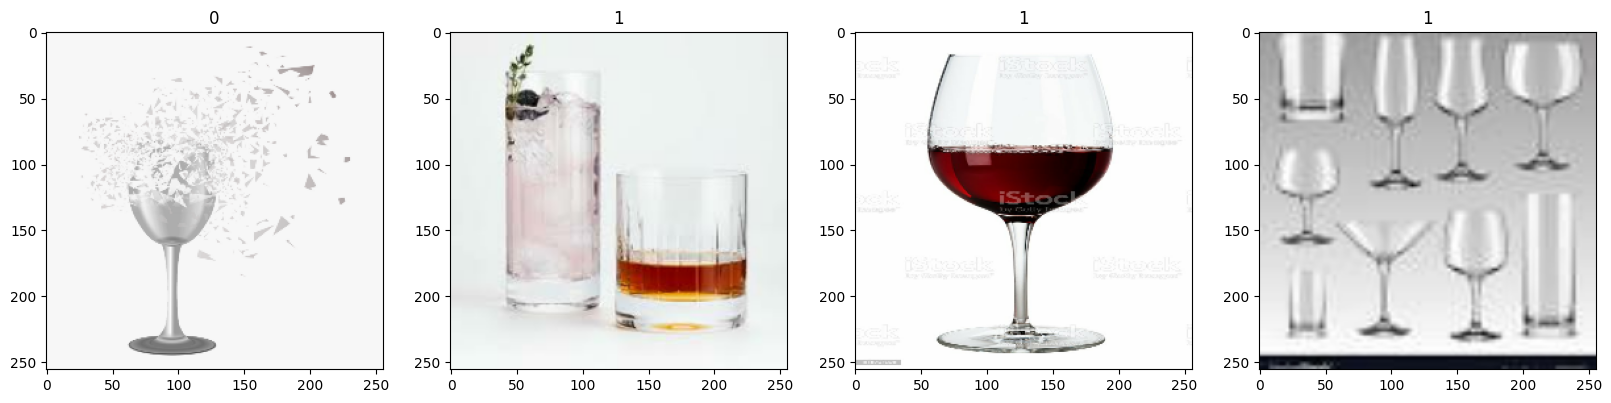

In [14]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Wstępne przetwarzanie danych

In [15]:
# przeskalowanie danych, w celu optymalizacji
data = data.map(lambda x,y: (x/255, y)) # funkcja .map umożliwia operacje na całym zestawie danych
data.as_numpy_iterator().next()

(array([[[[1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          ...,
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ]],
 
         [[1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          ...,
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ]],
 
         [[1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          ...,
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ]],
 
         ...,
 
         [[1.        , 1.        , 1.        ],
          [1.     

In [16]:
train_size = int(len(data)*.7) # część zestawu danych, która będzie odpowiedzalna za trenowanie modelu
val_size = int(len(data)*.2)+1 # część zestwu danych odpowiedzialna za walidacje
test_size = int(len(data)*.1)+1 # część zestawu danych odpowiedzialna za końcowe testy

In [17]:
train_size

9

In [18]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 5. Budowa modelu głębokiego uczenia

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [20]:
model = Sequential()

In [21]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [22]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

# 6. Trenowanie

In [24]:
logdir='logs'

In [25]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [26]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20


2022-11-13 11:36:06.102955: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500
2022-11-13 11:36:06.675229: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


9/9 [==============================] - 3s 106ms/step - loss: 1.2769 - accuracy: 0.5625 - val_loss: 0.6661 - val_accuracy: 0.6354
Epoch 2/20
9/9 [==============================] - 1s 112ms/step - loss: 0.6520 - accuracy: 0.6042 - val_loss: 0.5837 - val_accuracy: 0.7292
Epoch 3/20
9/9 [==============================] - 1s 111ms/step - loss: 0.5957 - accuracy: 0.6597 - val_loss: 0.5668 - val_accuracy: 0.6979
Epoch 4/20
9/9 [==============================] - 1s 112ms/step - loss: 0.5543 - accuracy: 0.6979 - val_loss: 0.5154 - val_accuracy: 0.6875
Epoch 5/20
9/9 [==============================] - 1s 112ms/step - loss: 0.4907 - accuracy: 0.7361 - val_loss: 0.4051 - val_accuracy: 0.8021
Epoch 6/20
9/9 [==============================] - 1s 110ms/step - loss: 0.4280 - accuracy: 0.7778 - val_loss: 0.4974 - val_accuracy: 0.7083
Epoch 7/20
9/9 [==============================] - 1s 110ms/step - loss: 0.3832 - accuracy: 0.7986 - val_loss: 0.3569 - val_accuracy: 0.8229
Epoch 8/20
9/9 [===============

In [27]:
# 7. Badanie wydajności, wykaz strat

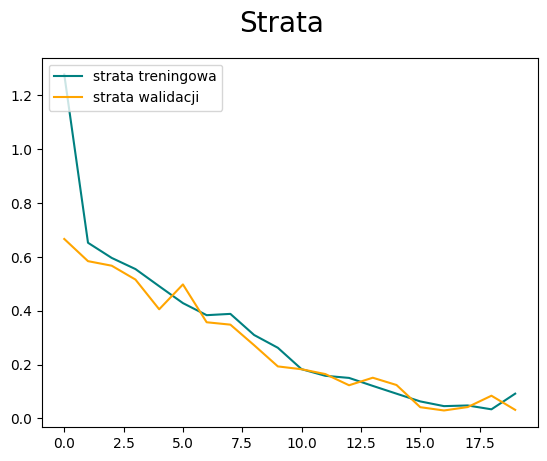

In [31]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='strata treningowa')
plt.plot(hist.history['val_loss'], color='orange', label='strata walidacji')
fig.suptitle('Strata', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [32]:
# 8. Badanie wydajności, wykaz dokładności

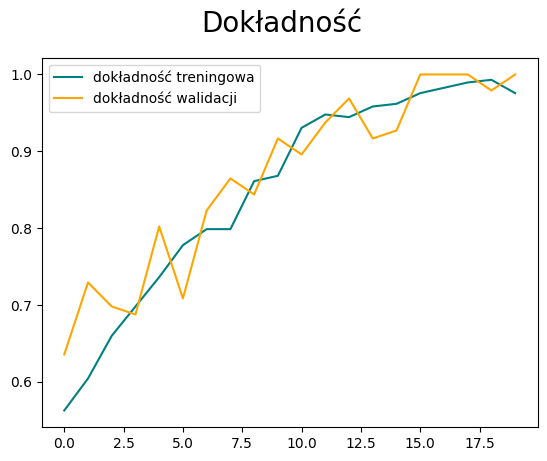

In [33]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='dokładność treningowa')
plt.plot(hist.history['val_accuracy'], color='orange', label='dokładność walidacji')
fig.suptitle('Dokładność', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [34]:
# 9. Ocena wydajności modelu

In [35]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [42]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [47]:
print(f'Precision:{precision.result().numpy()}, Recall:{recall.result().numpy()}, Accuracy:{accuracy.result().numpy()}')

Precision:0.0, Recall:0.0, Accuracy:0.0


In [46]:
# 10. Test

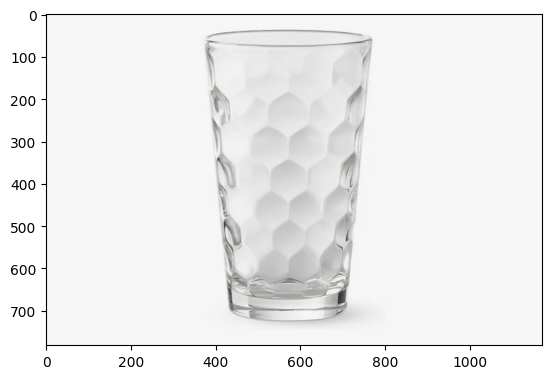

In [65]:
img = cv2.imread('success.png')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

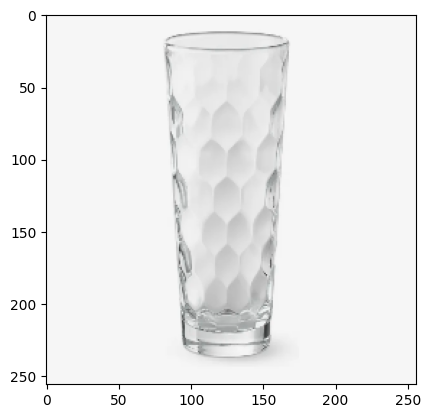

In [66]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [67]:
yhat  = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 11ms/step


In [68]:
yhat

array([[0.98304594]], dtype=float32)

In [69]:
if yhat > 0.5:
    print(f'Wskazany obraz został sklasyfikowany jako część prawidłowa')
else:
    print(f'Wskazany obraz został sklasyfikowany jako część uszkodzona')

Wskazany obraz został sklasyfikowany jako część prawidłowa


In [70]:
# 9. Zapis modelu

In [71]:
from tensorflow.keras.models import load_model

In [72]:
model.save(os.path.join('models', 'imageclassicationversionlive.h5'))

In [73]:
new_model = load_model(os.path.join('models', 'imageclassicationversionlive.h5'))

In [74]:
yhatnew = new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 33ms/step


In [75]:
if yhat > 0.5:
    print(f'Wskazany obraz został sklasyfikowany jako część prawidłowa')
else:
    print(f'Wskazany obraz został sklasyfikowany jako część uszkodzona')

Wskazany obraz został sklasyfikowany jako część prawidłowa
